In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Simulation parameters
resolution = 10  # pixels/um
pml_thickness = 2
cell_x = 16
cell_y = 16
cell_z = 16

sphere_radius = 1.0
sphere_eps = 2.56
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

In [ ]:
# Materials
default_material = mp.Medium(index=1.0)
sphere = mp.Sphere(
    center=mp.Vector3(0, 0, 1.5),  # place above substrate
    radius=sphere_radius,
    material=mp.Medium(epsilon=sphere_eps)
)

substrate = mp.Block(
    center=mp.Vector3(0, 0, -cell_z/4),
    size=mp.Vector3(mp.inf, mp.inf, cell_z/2),
    material=mp.Medium(epsilon=substrate_eps)
)

geometry = [sphere, substrate]

# Source: downward plane wave
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),  # xy plane source
        direction=mp.Z,
        eig_kpoint=mp.Vector3(0, 0, -1),
        eig_band=1,
        eig_match_freq=True
    )
]

# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    default_material=default_material
)

# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)



-----------
Initializing structure...
time for choose_chunkdivision = 0.00241995 s
Working in 3D dimensions.
Computational cell is 16 x 16 x 16 with resolution 10
     sphere, center = (0,0,1.5)
          radius 1
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     block, center = (0,0,-4)
          size (1e+20,1e+20,8)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 18.0559 s
-----------
MPB solved for frequency_1(0,0,-1) = 1 after 105 iters
Meep progress: 0.05/60.0 = 0.1% done in 10.0s, 11999.6s to go
on time step 1 (time=0.05), 10.008 s/step
Meep progress: 1.2000000000000002/60.0 = 2.0% done in 14.1s, 693.3s to go
on time step 24 (time=1.2), 0.179914 s/step
Meep progress: 2.5/60.0 = 4.2% done in 18.2s, 418.5s to go
on time step 50 (time=2.5), 0.155564 s/step
Meep progress: 3.6/60.0 = 6.0% done in 22.3s, 349.7s to go
on time step 72 (time=3.6), 0.187392 s/step
Meep progress: 4.75/60.0 = 7.9% done in 26.3s, 306.3s to go
on time step 95 (time=4.75), 0.174386 s/step
Meep progress: 5.800000000000001/60.0 = 9.7% done in 30.3s, 283.5s to go
on time step 116 (time=5.8), 0.190743 s/step
Meep progress: 6.9/60.0 = 11.5% done in 34.4s, 264.6s to go
on time step 138 (time=6.9), 0.184069 s/step
Meep progress: 8.200000000000001/60.0 = 13.7% done in 38.6s, 243.6s to go
on t

Flux through top: 16.750816
Flux through bottom: -269.148455
Flux through left: 4.600653
Flux through right: -4.600699
Flux through front: 4.502780
Flux through back: -4.502767


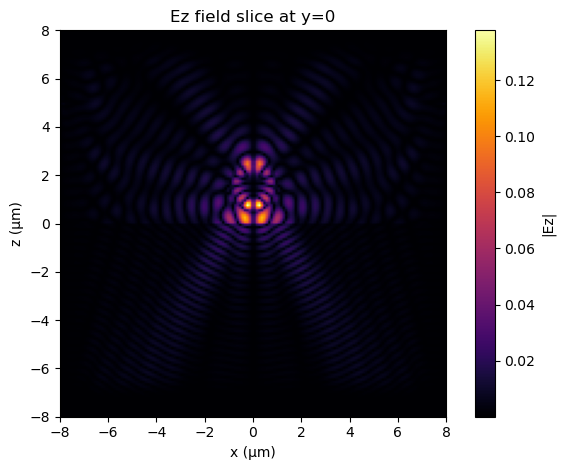

In [4]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Get field data for visualization
ez_slice = sim.get_array(center=mp.Vector3(),
                         size=mp.Vector3(cell_x, 0, cell_z),
                         component=mp.Ez)

plt.figure(dpi=100)
plt.imshow(np.abs(ez_slice.T), cmap='inferno', origin='lower', extent=[-cell_x/2, cell_x/2, -cell_z/2, cell_z/2])
plt.colorbar(label='|Ez|')
plt.xlabel('x (µm)')
plt.ylabel('z (µm)')
plt.title('Ez field slice at y=0')
plt.tight_layout()
plt.show()